## 3.5 The Influence of Network Topologes

In Sec. 3.2 and 3.3, it is established that both ATC-DGD and AWC-DGD suffers from a limiting bias:

\begin{align}
\limsup_{k\to \infty} \frac{1}{n}\sum_{i=1}^n \|x_i^{(k)} - x^\star \|^2 = O\Big( \frac{\alpha^2 \rho^2 b^2}{(1-\rho)^2}\Big) 
\end{align}

where $x^\star$ is the glboal solution to the optimization problem, $\alpha$ is the step-size, $\rho = \max\{|\lambda_2(W), \lambda_n(W)|\}$ and $b^2 = \frac{1}{n}\sum_{i=1}^n \|\nabla f_i(x^\star)\|^2$ denotes the data heterogeneity between nodes. Quantity $1-\rho$ measures the connectivity of the network topology. It is observed that $1-\rho$ can siginificantly affects the limiting bias especially when $1-\rho \to 0$. This section will examine how different network topologies will affect the limiting bias of ATC-DGD.

### 3.5.1 Connectivity and maximum degree of commonly-used topology  

The following table, which we have discussed in Sec. 2.7, summarizes the connectivity (i.e., $1-\rho$) and the maximum degree of some common network topologes. The combination matrix $W$ of the undirected topologies, i.e., the ring, 2D-mesh, and fully-connected topology, are generated through the Matropolis-Hastings  rule (see Sec. 2.3), while the combination matrix of exponential-2 topology (which is a directed network) is genereted through the Averaging rule (see Sec. 2.4). 


| Network topology | connectivity ($1-\rho$) | maximum degree |
| -: | :-: | :-: |
| Undirected Ring | $O(\frac{1}{n^2})$ | 2 |
| Undirected 2D-Mesh | $O(\frac{1}{n})$ | 4 |
| Exponential-2 | $O(\frac{1}{\ln(n)})$ | $\ln(n)$ |
| Fully connected| $1$ |$n-1$ |  

- **Connectivity**: the larger $1-\rho$ is, the better the network connectivity is, and the smaller the limiting bias that DGD has. Generally speaking, dense network has better connectivity.


- **Maximum degree:** Maximum degree influences the communicaiton efficiency of *one step* of the average consensus, i.e., $x_i^{k+1} = \sum_{j=1}^n w_{ij} x_j^k$. Apparently, more non-zero $w_{ij}$'s imply more communications. In the extreme example of fully connected network, each agent will exchange information with $n-1$ neighbors to conduct avearging. In contrast, each agent in the undirected ring will only need to communicate with 2 neighbors to finish one update, which is more communication efficient. Generally speaking, sparse network has smaller maximum degree


- **Trade-off:** If the network topology can be designed freely, the exponential-2 graph empically reaches a nice trade-off between per-iteration communicaiton efficiency and the convergence rate, see the Table above.

### 3.5.2 Examine the influence of network topology on DGD

In this section, we examine the influence of different network topologies on the limiting bias of DGD. The code is  the same as in Sec.3.2. The different is we will test ATC-DGD's performance with different topologies.

#### 3.5.2.1 Set up BlueFog

In the following code, you should be able to see the id of your CPUs. We use 8 CPUs to conduct the following experiment.

In [1]:
import ipyparallel as ipp
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

rc = ipp.Client(profile='bluefog')
print(rc.ids)
dview = rc[:] # A DirectView of all engines
dview.block=True

[0, 1, 2, 3, 4, 5, 6, 7]


In [2]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

bf.init()
print(f"Hello, I am {bf.rank()} among {bf.size()} processes")

[stdout:0] Hello, I am 2 among 8 processes
[stdout:1] Hello, I am 6 among 8 processes
[stdout:2] Hello, I am 3 among 8 processes
[stdout:3] Hello, I am 1 among 8 processes
[stdout:4] Hello, I am 0 among 8 processes
[stdout:5] Hello, I am 5 among 8 processes
[stdout:6] Hello, I am 7 among 8 processes
[stdout:7] Hello, I am 4 among 8 processes


In [3]:
dview = rc[:] # A DirectView of all engines
dview.block=True

# Push the data into all workers
dview.push({'seed': 2021}, block=True)

[None, None, None, None, None, None, None, None]

In [4]:
%%px
print("I received seed as value: ", seed)

[stdout:0] I received seed as value:  2021
[stdout:1] I received seed as value:  2021
[stdout:2] I received seed as value:  2021
[stdout:3] I received seed as value:  2021
[stdout:4] I received seed as value:  2021
[stdout:5] I received seed as value:  2021
[stdout:6] I received seed as value:  2021
[stdout:7] I received seed as value:  2021


Congratulations! Your BlueFog is initialized and tested successfully.

#### 3.2.4.2 Generate local data $A_i$ and $b_i$

In [5]:
%%px

def generate_data(m, n, x_o):
    
    A = torch.randn(m, n).to(torch.double)
#     x_o = torch.randn(n, 1).to(torch.double)
    ns = 0.1*torch.randn(m, 1).to(torch.double)
    b = A.mm(x_o) + ns
        
    return A, b

#### 3.2.4.3 Distributed gradient descent method

In [6]:
%%px

def distributed_grad_descent(A, b, maxite=5000, alpha=1e-1):

    x_opt = torch.zeros(n, 1, dtype=torch.double)

    for _ in range(maxite):
        # calculate local gradient 
        grad_local = A.t().mm(A.mm(x_opt) - b)
        
        # global gradient
        grad = bf.allreduce(grad_local, name='gradient')

        # distributed gradient descent
        x_opt = x_opt - alpha*grad

    grad_local = A.t().mm(A.mm(x_opt) - b)
    grad = bf.allreduce(grad_local, name='gradient')  # global gradient

    # evaluate the convergence of distributed gradient descent
    # the norm of global gradient is expected to 0 (optimality condition)
    global_grad_norm = torch.norm(grad, p=2)
    if bf.rank() == 0:
        print("[Distributed Grad Descent] Rank {}: global gradient norm: {}".format(bf.rank(), global_grad_norm))

    return x_opt

In the following code we run distributed gradient descent to achieve the global solution $x^\star$ to the optimization problem. To validate whether $x^\star$ is optimal, it is enough to examine $\frac{1}{n}\sum_{i=1}^n \nabla f_i(x^\star) = 0$.

In [7]:
m, n = 20, 5

# jupyter engine generate a reference solution x_o and push it to each worker
x_o = torch.randn(n, 1).to(torch.double)
dview.push({'x_o': x_o}, block=True)

[None, None, None, None, None, None, None, None]

In [8]:
%%px

m, n = 20, 5
A, b = generate_data(m, n, x_o)
x_opt = distributed_grad_descent(A, b, maxite=300, alpha=1e-2)

[stdout:4] [Distributed Grad Descent] Rank 0: global gradient norm: 1.2691123609414696e-14


#### 3.2.4.3 Decentralized gradient descent method

In this section, we depict the convergence curve of the decentralied gradient descent (the ATC version). We will utilize the $x^\star$ achieved by distributed gradient descent as the optimal solution. First, we define one step of the ATC-DGD method.

In [9]:
%%px 

def ATC_DGD_one_step(x, x_opt, A, b, alpha=1e-2):
    
    # one-step ATC-DGD. 
    # The combination weights have been determined by the associated combination matrix.
    
    grad_local = A.t().mm(A.mm(x) - b)      # compute local grad
    y = x - alpha*grad_local                # adapte
    x_new = bf.neighbor_allreduce(y)        # combination
    
    # the relative error: |x^k-x_gloval_average|/|x_gloval_average|
    rel_error = torch.norm(x_new-x_opt, p=2)/torch.norm(x_opt,p=2)

    return x_new, rel_error

Next we run ATC-DGD algorithm.

In [14]:
%%px

# uncomment the code if you want to use that topology
G = topology_util.RingGraph(bf.size())           # Set topology as ring topology.
# G = topology_util.ExponentialTwoGraph(bf.size()) # Set topology as exponential-two topology.
bf.set_topology(G)

maxite = 200
x = torch.zeros(n, 1, dtype=torch.double)     # Initialize x
rel_error = torch.zeros((maxite, 1))
for ite in range(maxite):
    
    if bf.rank()==0:
        if ite%10 == 0:
            print('Progress {}/{}'.format(ite, maxite))
        
    x, rel_error[ite] = ATC_DGD_one_step(x, x_opt, A, b, alpha=3e-3) # you can adjust alpha to different values

[stdout:4] 
Progress 0/200
Progress 10/200
Progress 20/200
Progress 30/200
Progress 40/200
Progress 50/200
Progress 60/200
Progress 70/200
Progress 80/200
Progress 90/200
Progress 100/200
Progress 110/200
Progress 120/200
Progress 130/200
Progress 140/200
Progress 150/200
Progress 160/200
Progress 170/200
Progress 180/200
Progress 190/200


In the following, we adjust to differnt topologies to examine its influence on the convergence rate and limiting bias.

In [15]:
# uncomment one of the following code when corresponding graph is activated

rel_error_ring = dview.pull('rel_error', block=True, targets=7)
# rel_error_exp2 = dview.pull('rel_error', block=True, targets=7)

Text(0, 0.5, 'Relative error')

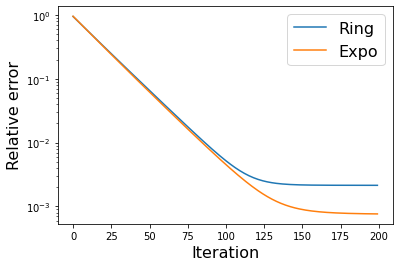

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogy(rel_error_ring)
plt.semilogy(rel_error_exp2)

plt.legend(['Ring', 'Expo'], fontsize=16)

plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)

It is observed that exponential-two graph enables DGD to converge to a more accurate solution due to its better-connected topology.